In [1]:
import numpy as np
import os
import math
import sys
import csv
import itertools
import yaml

from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from tqdm import tqdm
from enum import Enum
from typing import Optional
from r3m import load_r3m
import clip
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage, InterpolationMode
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd

from torch.nn import functional as nnf
import wandb

from datasets.dataset import CustomDataset, AttrDict 
from utils.visualize import visualize, showImages
from utils.beamsearch import beamsearch
from models.caption_model import ClipCaptionModel, MappingType
from utils.generating_captions import generate_annotations, generate_annotation

import config as CFG


mp.set_start_method('spawn')


/home/tim/anaconda3/envs/cap-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-02 02:27:47.131156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Visualize Calvin Data

In [ ]:
visualize()

In [ ]:
datapath_test= '.././test_data/D_D/task_D_D_episode.npz'
data = np.load(datapath_test)
print(list(data.keys()))
print(data['actions'].shape)
print(data['rel_actions'].shape)
print(data['rgb_static'].shape)
print(data['rgb_gripper'].shape)
print(data['scene_obs'])

## Captioning

find sutiable caption for optimization

In [ ]:
path = CFG.datapath_training_parsed + "/lang_annotations/auto_lang_ann.npy"
#path = CFG.datapath_val_abcd + "/lang_annotations/auto_lang_ann.npy"

annotations = np.load(path, allow_pickle=True).item()
annotations = annotations["language"]["ann"]


unique, counts = np.unique(annotations, return_counts=True)
print(dict(zip(unique, counts)))

### Data Loader

In [2]:
dataset = 'd'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

if dataset == 'abcd':
    datapath_training_parsed = CFG.datapath_training_abcd_parsed
    datapath_val_parsed = CFG.datapath_val_abcd_parsed
    caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_training_parsed)
    caption_path_val = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_val_parsed)
else:
    datapath_training_parsed = CFG.datapath_training_parsed
    datapath_val_parsed = CFG.datapath_val_parsed
    caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_training_parsed)
    caption_path_val = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_val_parsed)


# train_dataset = CustomDataset(datapath_dd_training, caption_path_training, tokenizer, max_seq_length)
observation_data = 'static_and_gripper'
train_dataset = CustomDataset(datapath_training_parsed, caption_path_training, tokenizer, CFG.max_seq_length, observation_data)
val_dataset  = CustomDataset(datapath_val_parsed, caption_path_val, tokenizer, CFG.max_seq_length, observation_data)

train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)



Test Data Loader

In [6]:
caption_path_training = '{}/lang_annotations/auto_lang_ann.npy'.format(datapath_training_parsed)
annotations = np.load(f"{caption_path_training}", allow_pickle=True).item()
annotations = list(zip(annotations["info"]["indx"], annotations["language"]["ann"]))
annotations[1]

((1441275, 1441316), 'push the switch downwards \n')

In [3]:
for idx, batch in enumerate(val_dataloader):
    if os.name == 'nt': 
        os.system('cls')
    else:
        os.system('clear')

    print("gpt_tokens: ", batch.gpt_tokens.shape)
    print("gpt_mask: ", batch.gpt_mask.shape)
    print(batch.instruction[0])
    print(list(zip(batch.caption_index[0].tolist(), batch.caption_index[1].tolist()))[0])
    print("actions: ", batch.actions.shape)
    print("state: ", batch.state.shape)
    print("observations: ", batch.observations.shape)
    print("batch at index done: ", idx)
    break


gpt_tokens:  torch.Size([16, 16])
gpt_mask:  torch.Size([16, 16])
turn on the green light 

(35722, 35764)
actions:  torch.Size([16, 64, 7])
state:  torch.Size([16, 64, 15])
observations:  torch.Size([16, 64, 2048])
batch at index done:  0


terminate called without an active exception
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1d3a18400>
Traceback (most recent call last):
  File "/home/tim/anaconda3/envs/cap-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/tim/anaconda3/envs/cap-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/tim/anaconda3/envs/cap-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tim/anaconda3/envs/cap-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tim/anaconda3/envs/cap-env/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = select

In [ ]:

clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text
clip_text_features = clip_text_encoder(clip.tokenize("grasp the blue block, then rotate it left").to(CFG.device))   #.detach().cpu().numpy()[()].squeeze(0)

print(clip_text_features.shape)

## Training

In [4]:
def validate(model: ClipCaptionModel):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(val_dataloader):

            data.observations = data.observations.to(CFG.device)
            data.actions = data.actions.to(CFG.device) 
            data.state = data.state.to(CFG.device) 
            #data.instruction = data.instruction.to(CFG.device)
            data.instruction = clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).to(CFG.device)
            data.gpt_tokens = data.gpt_tokens.to(CFG.device)
            data.gpt_mask = data.gpt_mask.to(CFG.device)
            outputs = model(data)

            logits = outputs.logits[:, data.observations.shape[1] - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)
            
            total_loss += loss.item()

    return total_loss / len(val_dataloader)

def train(model: ClipCaptionModel,
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = ""):

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    epochs = CFG.epochs
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )

    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, data in enumerate(train_dataloader):

            model.zero_grad()

            data.observations = data.observations.to(CFG.device)
            data.actions = data.actions.to(CFG.device)
            data.state = data.state.to(CFG.device)
            data.instruction = clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).to(CFG.device)
            data.gpt_tokens = data.gpt_tokens.to(CFG.device)
            data.gpt_mask = data.gpt_mask.to(CFG.device)
            
            outputs = model(data)

            logits = outputs.logits[:, data.observations.shape[1] - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            wandb.log({"loss": loss.item()})
            progress.update()
            if (idx+1) % 100 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
                #val_loss = validate(model)
                #wandb.log({"val_loss": val_loss})
        progress.close()
        if epoch % 1 == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model

### Load and Train Model

In [2]:
wandb.init(project="clipcalvin")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

prefix_length = 10
prefix_length_clip = 10
num_layers = 8
prefix_dim = 512
mapping_type = {'mlp': MappingType.MLP, 'transformer': MappingType.Transformer}["transformer"]

model = ClipCaptionModel(prefix_length, clip_length=prefix_length_clip, prefix_size=prefix_dim,
                          num_layers=num_layers, mapping_type=mapping_type)


clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

#output_dir = "./checkpoints/hulccap_abcd/run_1"
output_dir = '/media/tim/D/checkpoints_calvin/d_d_with_state'
train(model, output_dir=output_dir, output_prefix="hulccap_prefix")


NameError: name 'wandb' is not defined

## Evaluation

### find best model and write losses to csv

In [3]:
clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


def evaluate_loss(path, filename, dataloader):

    mapper_model = ClipCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
    mapper_model.load_state_dict(torch.load(path, map_location=CFG.device))
    mapper_model = mapper_model.eval()

    total_loss = 0
    for data in dataloader:

        data.observations = data.observations.to(CFG.device)
        data.actions = data.actions.to(CFG.device)
        data.state = data.state.to(CFG.device)
        data.instruction = clip_text_encoder(clip.tokenize(data.instruction).to(CFG.device)).to(CFG.device)
        data.gpt_tokens = data.gpt_tokens.to(CFG.device)
        data.gpt_mask = data.gpt_mask.to(CFG.device)

        outputs = mapper_model(data)

        with torch.no_grad():
            logits = outputs.logits[:, data.observations.shape[1] - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), data.gpt_tokens.flatten(), ignore_index=0)    
            total_loss += loss.item()
    return total_loss  / len(dataloader)

        

#model_dir = "./checkpoints/hulccap/run_1/"
#model_dir = "./checkpoints/hulccap/run_3_rgb_gripper/"
#csv_filepath = "./results/gripper_loss.csv"
#model_dir = "./checkpoints/hulccap/run_4_rgb_gripper_and_static/"
#csv_filepath = "./results/gripper_and_static_loss.csv"

#model_dir = "./checkpoints/hulccap_abcd/run_1/"
#csv_filepath = "./results/abc_d/abcd_loss.csv"

model_dir = "/media/tim/D/checkpoints_calvin/d_d_with_state"
csv_filepath = "./results/d_d/dd_state_loss.csv"

best_model = None
best_loss = float('inf')
results = []

for filename in os.listdir(model_dir):
    epoch = filename[-6:-3]
    try:
        epoch_ = int(epoch)
        print(epoch)
        model_path = os.path.join(model_dir, filename)
        val_loss = evaluate_loss(model_path, filename, val_dataloader)
        train_loss = evaluate_loss(model_path, filename, train_dataloader)
        print(filename, ' val_loss: ', val_loss, ' train_loss: ', train_loss)
        results.append({'epoch': epoch, 'filename': filename,  'val_loss': val_loss, 'train_loss': train_loss})
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = filename
    except:
        print("error getting epoch number")

print("best model: ", best_model, ' loss: ', best_loss)
results.sort(key=lambda x: x['epoch'])

with open(csv_filepath, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['epoch', 'filename', 'val_loss', 'train_loss'])
    writer.writeheader()
    for result in results:
        writer.writerow(result)
    
print("wrote results to ", csv_filepath)

048
hulccap_prefix-048.pt  val_loss:  0.3739589136093855  train_loss:  0.16605763622440653
050
hulccap_prefix-050.pt  val_loss:  0.3862630003131926  train_loss:  0.15554690033754456
021
hulccap_prefix-021.pt  val_loss:  0.32431508507579565  train_loss:  0.27557484448141767
020
hulccap_prefix-020.pt  val_loss:  0.3225051364861429  train_loss:  0.28159890990019587
043
hulccap_prefix-043.pt  val_loss:  0.3491180296987295  train_loss:  0.18965323315788282
031
hulccap_prefix-031.pt  val_loss:  0.32688345783390105  train_loss:  0.2456648363688282
003
hulccap_prefix-003.pt  val_loss:  0.7358964579179883  train_loss:  0.7336675318602089
011
hulccap_prefix-011.pt  val_loss:  0.41223602229729295  train_loss:  0.3813358071808503
022
hulccap_prefix-022.pt  val_loss:  0.32227043993771076  train_loss:  0.27865039995897595
036
hulccap_prefix-036.pt  val_loss:  0.3363232898991555  train_loss:  0.23294739406613918
046
hulccap_prefix-046.pt  val_loss:  0.37243789760395885  train_loss:  0.187368894964920

### Plot losses

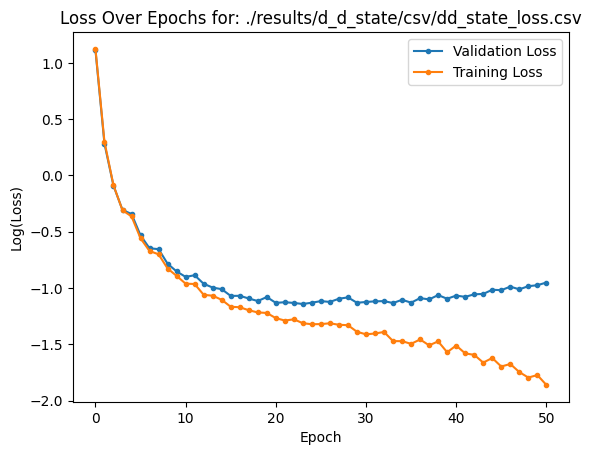

best loss for  ./results/d_d_state/csv/dd_state_loss.csv  for epoch  23 :  0.3192366738803684


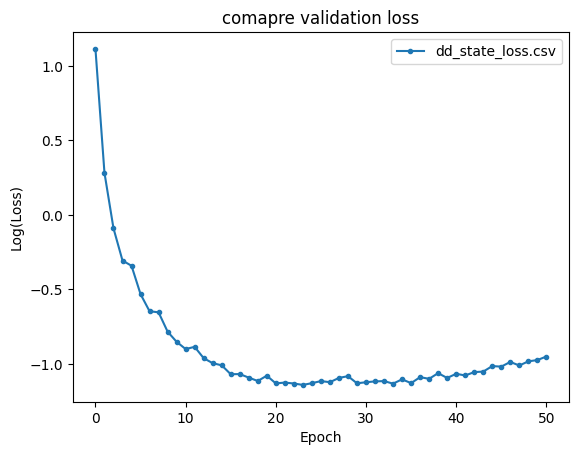

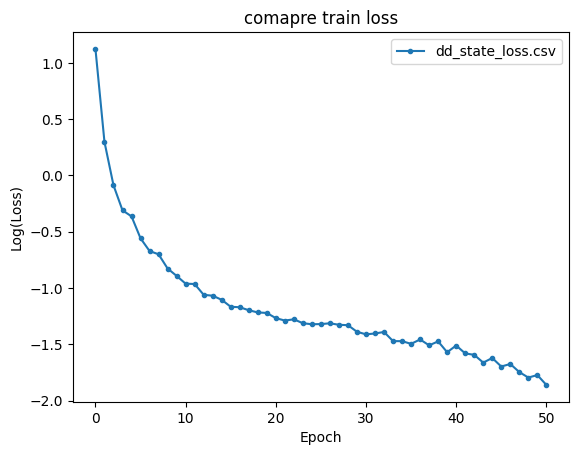

In [4]:
#csv_folder = "./results/abc_d/csv"
#csv_folder = "./results/d_d/csv"
csv_folder = "./results/d_d_state/csv"

for filename in os.listdir(csv_folder):
    csv_filepath = os.path.join(csv_folder, filename)

    loss_data = pd.read_csv(csv_filepath)
    epochs = loss_data['epoch']
    val_loss = loss_data['val_loss']
    train_loss = loss_data['train_loss']

    val_loss = np.log(val_loss)
    train_loss = np.log(train_loss)

    plt.plot(epochs, val_loss, label='Validation Loss', marker='.')
    plt.plot(epochs, train_loss, label='Training Loss', marker='.')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    title = 'Loss Over Epochs for: ' + csv_filepath
    plt.title(title)
    plt.legend()
    #plt.savefig('./results/abc_d/loss.png')
    plt.show()

    best_val_loss = float('inf')
    best_epoch = 0
    for epoch, val_loss in enumerate(loss_data['val_loss']):
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
    print("best loss for ", csv_filepath, " for epoch ", best_epoch, ": ", best_val_loss)


for filename in os.listdir(csv_folder):
    csv_filepath = os.path.join(csv_folder, filename)
    loss_data = pd.read_csv(csv_filepath)
    epochs = loss_data['epoch']
    val_loss = loss_data['val_loss']
    val_loss = np.log(val_loss)
    plt.plot(epochs, val_loss, label=filename, marker='.')

plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
title = 'comapre validation loss'
plt.title(title)
plt.legend()
plt.show()


for filename in os.listdir(csv_folder):
    csv_filepath = os.path.join(csv_folder, filename)
    loss_data = pd.read_csv(csv_filepath)
    epochs = loss_data['epoch']
    train_loss = loss_data['train_loss']
    val_loss = np.log(train_loss)
    plt.plot(epochs, val_loss, label=filename, marker='.')

plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
title = 'comapre train loss'
plt.title(title)
plt.legend()
plt.show()

### Evaluate best model

Greedy decoding

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# path_best = "./checkpoints/hulccap/run_1/hulccap_prefix-032.pt"
path_best = "./checkpoints/hulccap/run2_with_stoptoken/hulccap_prefix-028.pt"
best_model = ClipCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
best_model.load_state_dict(torch.load(path_best, map_location=CFG.device))
best_model = best_model.eval()

#for data in val_dataloader:
for data in itertools.islice(val_dataloader, 0, 4):
    instruction_ground = data.instruction

    data.observations = data.observations.to(CFG.device)
    data.actions = data.actions.to(CFG.device)
    data.gpt_tokens = data.gpt_tokens.to(CFG.device)
    data.gpt_mask = data.gpt_mask.to(CFG.device)

    outputs = best_model(data)
    
    for i in range(len(data.instruction)):
        print("INSTRUCTION:", instruction_ground[i])
        

        with torch.no_grad():
            generated_token = outputs.logits[i].argmax(dim=-1)
            print(outputs.logits[i].shape)
            print(generated_token.shape)

            # remove duplicates
            result = []
            for i in range(len(generated_token)):
                word = generated_token[i]
                if word not in result or result[-1] != word:
                    result.append(word)
            result_tensor = torch.tensor(result)

            generated_text = tokenizer.decode(result_tensor)
            print("Generated Caption:", generated_text)

Beam decoding

INSTRUCTION GROUND: turn on the green light 
  at index:  [tensor([35722]), tensor([35764])]
[('push down the button to turn on the green light \n', tensor(0.8841, device='cuda:0')), ('push the button to turn on the green light \n', tensor(0.7643, device='cuda:0')), ('push down the button to turn on the led light \n', tensor(0.7569, device='cuda:0')), ('turn on the led lamp \n', tensor(0.7342, device='cuda:0')), ('turn on the green lamp \n', tensor(0.7152, device='cuda:0'))]


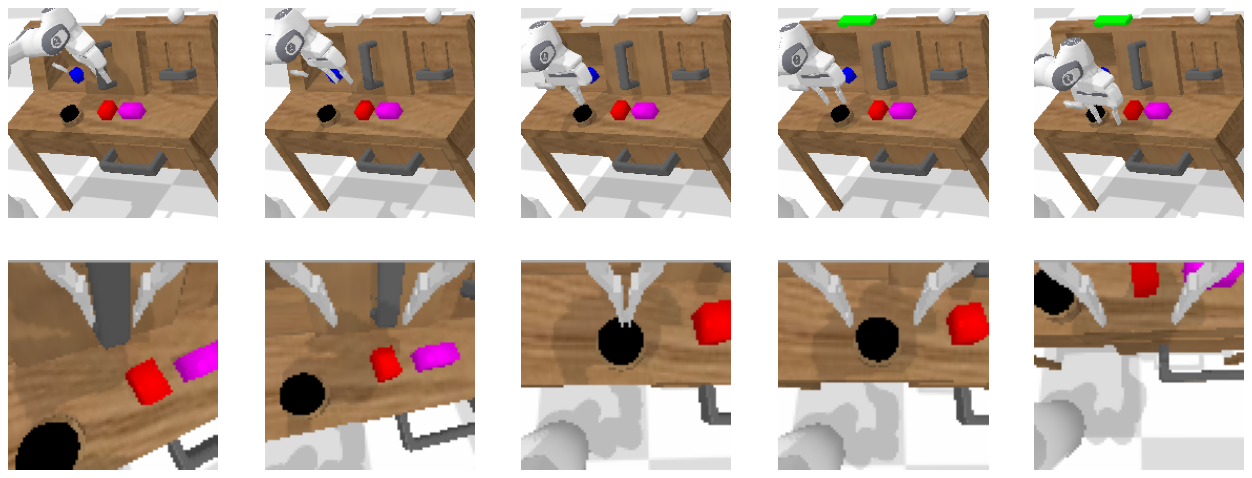

INSTRUCTION GROUND: lift the pink block lying in the drawer 
  at index:  [tensor([231377]), tensor([231411])]
[('go towards the pink block in the drawer and lift it \n', tensor(0.8745, device='cuda:0')), ('lift the pink block lying in the drawer \n', tensor(0.8420, device='cuda:0')), ('go towards the pink block in the drawer and grasp it \n', tensor(0.8149, device='cuda:0')), ('lift the pink block in the drawer \n', tensor(0.7771, device='cuda:0')), ('pick up the pink block from the drawer \n', tensor(0.7453, device='cuda:0'))]


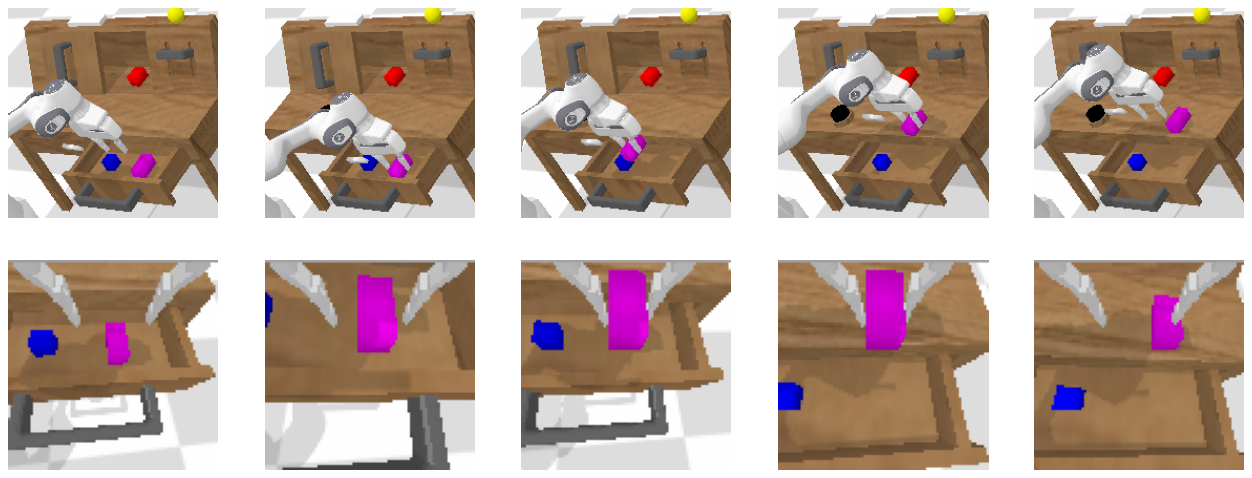

In [7]:
#path_best = "./checkpoints/hulccap/run_1/hulccap_prefix-032.pt"
#path_best = "./checkpoints/hulccap/run2_with_stoptoken/hulccap_prefix-028.pt"
dataset = 'd'
if dataset == 'abcd':
    path_best = "./checkpoints/hulccap_abcd/run_1/hulccap_prefix-016.pt"
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CFG.num_workers)
else:
    #path_best = "./checkpoints/hulccap/run_4_rgb_gripper_and_static/hulccap_prefix-029.pt"
    #val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CFG.num_workers)
    path_best = "./checkpoints/hulccap/run_5_state/hulccap_prefix-best.pt"
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CFG.num_workers)


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

clip_model, _ = clip.load("ViT-B/32", device=CFG.device, jit=True)
clip_text_encoder = clip_model.encode_text

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

best_model = ClipCaptionModel(prefix_length=10, clip_length=10).to(CFG.device)
best_model.load_state_dict(torch.load(path_best, map_location=CFG.device))
best_model = best_model.eval()

for data in itertools.islice(val_dataloader, 0, 2):

    instruction_ground = data.instruction
    index_ground = data.caption_index

    data.observations = data.observations.to(CFG.device)
    data.actions = data.actions.to(CFG.device)
    data.state = data.state.to(CFG.device)
    data.gpt_tokens = data.gpt_tokens.to(CFG.device)
    data.gpt_mask = data.gpt_mask.to(CFG.device)

    for i in range(len(data.instruction)):
        print("INSTRUCTION GROUND:", instruction_ground[i], " at index: ", index_ground)  
        # print(data.observations.shape)
        src = AttrDict(observations=data.observations, actions=data.actions, state=data.state)
        behaviour_encoding = best_model.behaviour_encoder(src)
        prefix_embed = best_model.project_to_gpt(behaviour_encoding)
        generated_caption =  beamsearch(best_model, tokenizer, prefix_embed)
        print(generated_caption)
        showImages(index_ground[0].item(), CFG.datapath_val)

### Persicion and recall of generated captions

In [30]:
#model_path = "./checkpoints/hulccap_abcd/run_1/hulccap_prefix-016.pt"
#datapath_val = CFG.datapath_val_abcd_parsed
#csv_file = './results/abc_d/precision_recall.csv'

model_path = "./checkpoints/hulccap/run_5_state/hulccap_prefix-best.pt"
datapath_val = CFG.datapath_val_parsed
csv_file = './results/d_d_state/precision_recall.csv'

with open('ann.yaml', 'r') as ann_yaml:
    annotation_data = yaml.safe_load(ann_yaml)

thresholds = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

predicted_captions = []

for data in tqdm(val_dataset):
    instruction = data.instruction
    for key, values in annotation_data.items():
        if instruction.rstrip(' \n') in values:
            instruction = key
    generated_annotation = generate_annotation(data.caption_index[0], CFG.datapath_val_abcd_parsed, model_path)[0]
    score = generated_annotation[1].item()
    caption = generated_annotation[0]
    for key, values in annotation_data.items():
        if caption.rstrip(' \n') in values:
            caption = key
    predicted_captions.append((instruction == caption, score))

results = []
for threshold in thresholds:
    tp = 0
    fp = 0
    fn = 0
    for is_correct, score in predicted_captions:
        if score >= threshold:
            if is_correct:
                tp += 1
            else:
                fp += 1
        elif is_correct:
            fn += 1

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0   

    print(f"Threshold: {threshold}")
    print(f"TP: {tp}")
    print(f"FP: {fp}")
    print(f"FN: {fn}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    results.append([threshold, tp, fp, fn, recall, precision])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Threshold', 'TP', 'FP', 'FN', 'Recall', 'Precision'])
    for result in results:
        writer.writerow(result)

print(f"done, wrote results to {csv_file}")

  0%|          | 0/1087 [00:00<?, ?it/s]

100%|██████████| 1087/1087 [43:23<00:00,  2.39s/it]

Threshold: 0.0
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.05
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.1
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.15
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.2
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.25
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.3
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.35
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.4
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.45
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.5
TP: 584
FP: 503
FN: 0
Recall: 1.0
Precision: 0.5372585096596136
Threshold: 0.55
TP: 584
FP: 491
FN: 0
Recall: 1.0
Precision: 0.5432558139534883
Threshold: 0.6
TP: 584
FP: 467
FN: 0
Recall: 1

PR-Curve

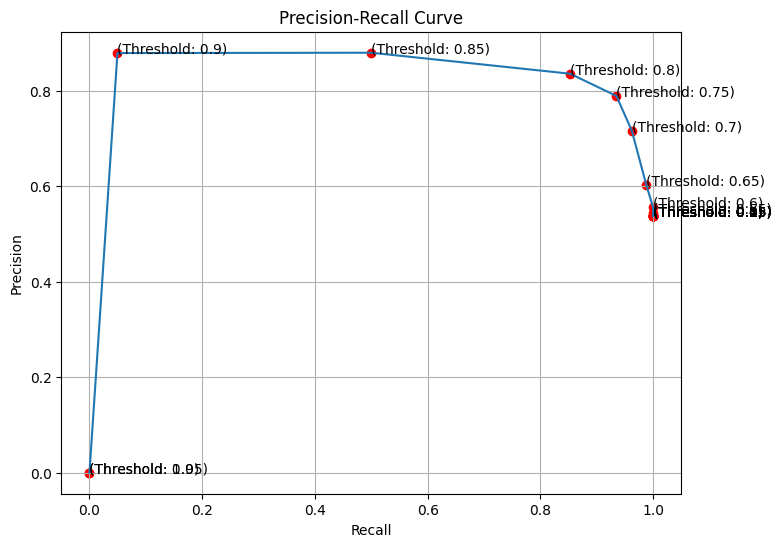

In [46]:
#csv_file = './results/abc_d/precision_recall.csv'
csv_file = './results/d_d/precision_recall.csv'

data = pd.read_csv(csv_file)

precision = data['Precision']
recall = data['Recall']
thresholds = data['Threshold']

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
for i, threshold in enumerate(thresholds):
    plt.scatter(recall[i], precision[i], marker='o', color='red')
    plt.text(recall[i], precision[i], f'(Threshold: {threshold})')

plt.grid(True)
plt.show()

### Generate new caption using beam and sliding window 

find lowest and highest episode

In [ ]:
datafiles = os.listdir(CFG.datapath_training_parsed)

indices = next(iter(np.load(f"{CFG.datapath_training}/scene_info.npy", allow_pickle=True).item().values()))
print(indices)

lowest = float('inf')
highest = float('-inf')
# Loop through and print the file names
for file in datafiles:
    try:
        epi_num = file.split('_')[1].split('.')[0]
        epi_num = int(epi_num)
        if epi_num < lowest:
            lowest = epi_num
        if epi_num > highest:
            highest = epi_num
    except:
         print(f"Skipping '{file}'")

print("lowest episode: ",lowest)
print("highest episode: ",highest)

test caption generation

In [ ]:

generated_captions = generate_annotations(53819, 54000, 0.85, CFG.datapath_training_parsed)
for generated_caption in generated_captions:
    print(generated_caption)
    showImages(generated_caption[1][0], CFG.datapath_training)

write new annotations to file

In [ ]:
path = CFG.datapath_training + "/lang_annotations/auto_lang_ann.npy"
annotations = np.load(path, allow_pickle=True).item()
annotations = annotations['language']['ann']

with open('ann.yaml', 'r') as yaml_file:
    data = yaml.safe_load(yaml_file)

for annotation in annotations:
    check_annotation = annotation
    missing = True
    for key, value in data.items():
        if isinstance(value, list):
            if check_annotation in value:
                print(f"{check_annotation} -> '{key}'.")
                missing = False
    if missing:
        print(missing)


Write new training captions to npy and json

In [ ]:
# change embeddings on old captions
if not os.path.exists(CFG.modifed_emb_path):
    data = np.load(CFG.datapath_training + "/lang_annotations/auto_lang_ann.npy", allow_pickle=True).item()
    modified_emb = data.copy()
    embedding_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
    embeddings= []
    for annotation in modified_emb['language']['ann']:
        embedding = [embedding_model.encode(annotation)]
        embeddings.append(embedding)
    modified_emb['language']['emb'] = np.array(embeddings)
    np.save(CFG.modifed_emb_path, modified_emb)


# generate new captions
embedding_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
with open('ann.yaml', 'r') as ann_yaml:
    annotation_data = yaml.safe_load(ann_yaml)

generated_captions = generate_annotations(CFG.start_epi_dd, CFG.end_epi_dd, 0.85, CFG.datapath_training_parsed)
annotations = []
embeddings = []
tasks = []
indx = []
episodes = []
print("creating npy data...")
for generated_caption in tqdm(generated_captions):
    annotation = generated_caption[0][0][0].replace(' \n', '')

    for key, value in annotation_data.items():
        if isinstance(value, list):
            if annotation in value:
                annotations.append(annotation)
                embedding = [embedding_model.encode(annotation)]
                embeddings.append(embedding)
                tasks.append(key)
                index = generated_caption[1]
                indx.append(index)
                break

caption_dict = {
    'language': {
        'ann': annotations,
        'task': tasks,
        'emb': np.array(embeddings)
    },
    'info': {
        'episodes': episodes,
        'indx': indx,
    }
}

np.save(CFG.generated_captions_path, caption_dict)
print("done")

combine captions to one file

In [ ]:
captions = np.load(CFG.modifed_emb_path, allow_pickle=True).item()

captions_generated = np.load(CFG.generated_captions_path, allow_pickle=True).item()

combined_captions = {}

for data in ['language', 'info']:
    combined_captions[data] = {}
    for key in captions[data].keys():
        if key == 'emb':
            combined_captions[data][key] = np.concatenate([captions[data][key], captions_generated[data][key]], axis=0)
        else:
            combined_captions[data][key] = captions[data][key] + captions_generated[data][key]

np.save(CFG.combined_captions_path, combined_captions)

In [ ]:
def check_structure(path):
    
    annotations = np.load(path, allow_pickle=True).item()
    keys = annotations.keys()

    print(keys)
    print(annotations['language'].keys())
    print(annotations['info'].keys())

    print(annotations['info']['episodes'])
    print(annotations['language']['ann'][0])
    print(annotations['language']['task'][0])
    print(annotations['language']['emb'].shape)
    print(annotations['info']['indx'][0])

path_base = CFG.datapath_training + "/lang_annotations/auto_lang_ann.npy"
path_generated = CFG.generated_captions_path
path_combined = CFG.combined_captions_path

check_structure(path_base)
print('\n')
check_structure(path_generated)
print('\n')
check_structure(path_combined)